### Boris Johnson - exploration

In [1]:
!pip install textblob

In [2]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /home/alibor/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/alibor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/alibor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alibor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /home/alibor/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/alibor/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [3]:
!pip install gensim

In [97]:
import json
import pandas as pd
import os
from textblob import TextBlob
import nltk
import tweepy
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

In [5]:

print(os.getcwd())

/home/alibor/code/reichardtma/prestweets/notebooks


In [6]:
data = None

tweets_df = pd.read_csv('borisjohnson_tweets.csv')
boris = tweets_df[["id", "url", "date", "content",
                    "hashtags", "cashtags", "media", "lang"]]
if data is None:
    data = boris
else:
    data = data.append(df)

boris.content

0       In 2019 I promised to equalise National Insura...
1       I spoke to President @ZelenskyyUa and reiterat...
2       Those lost to Covid will never be out of our h...
3       We're cutting taxes for hardworking people:\n ...
4       The UK &amp; Ireland bid for the UEFA Euro 202...
                              ...                        
4327    Again Mili says he would make cuts - on what a...
4328    How is Mili going to cut the deficit? He can't...
4329    Good to see yet more business leaders backing ...
4330    Cracking morning in Hendon with a great swathe...
4331    Good evening Twittersphere. This is Boris, com...
Name: content, Length: 4332, dtype: object

In [7]:
boris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        4332 non-null   int64  
 1   url       4332 non-null   object 
 2   date      4332 non-null   object 
 3   content   4332 non-null   object 
 4   hashtags  1428 non-null   object 
 5   cashtags  0 non-null      float64
 6   media     2242 non-null   object 
 7   lang      4332 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 270.9+ KB


In [8]:
boris.content.describe

<bound method NDFrame.describe of 0       In 2019 I promised to equalise National Insura...
1       I spoke to President @ZelenskyyUa and reiterat...
2       Those lost to Covid will never be out of our h...
3       We're cutting taxes for hardworking people:\n ...
4       The UK &amp; Ireland bid for the UEFA Euro 202...
                              ...                        
4327    Again Mili says he would make cuts - on what a...
4328    How is Mili going to cut the deficit? He can't...
4329    Good to see yet more business leaders backing ...
4330    Cracking morning in Hendon with a great swathe...
4331    Good evening Twittersphere. This is Boris, com...
Name: content, Length: 4332, dtype: object>

## Pre-processing

In [9]:
def remove_punctuation(text):
    text = ''.join([i for i in text if i not in string.punctuation])
    return text

In [10]:
def lower_case(text):
    text = text.lower()
    return text

In [11]:
def remove_numbers(text):
    text = ''.join(word for word in text if not word.isdigit())
    return text

In [12]:
!pip install tweepy

In [13]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = ''.join(lemmatizer.lemmatize(word) for word in text)
    return text

In [14]:
def stop_words(text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text) 
    text = ' '.join(w for w in word_tokens if not w in stop_words)
    return text

In [15]:
boris['clean_translation'] = boris['content'].apply(lemmatize).\
apply(lower_case).apply(remove_numbers).apply(remove_punctuation).apply(stop_words)
boris.head(3)

,id,url,date,content,hashtags,cashtags,media,lang,clean_translation
0,1506711585468911621,https://twitter.com/BorisJohnson/status/150671...,2022-03-23 19:16:49+00:00,In 2019 I promised to equalise National Insura...,['SpringStatement2022'],NaN,NaN,en,promised equalise national insurance income ta...
1,1506684769559621633,https://twitter.com/BorisJohnson/status/150668...,2022-03-23 17:30:16+00:00,I spoke to President @ZelenskyyUa and reiterat...,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.Photo', '...",en,spoke president zelenskyyua reiterated uk ’ ho...
2,1506675316273692678,https://twitter.com/BorisJohnson/status/150667...,2022-03-23 16:52:42+00:00,Those lost to Covid will never be out of our h...,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.Photo', '...",en,lost covid never hearts minds today reflect na...


In [16]:
def polarity(s):
    pol = TextBlob(s)
    pol = pol.sentiment[0]
    return pol

def objectivity(s):
    obj = TextBlob(s)
    obj = obj.sentiment[1]
    return obj

In [17]:
boris['polarity'] = boris['clean_translation'].apply(polarity)
boris['objectivity'] = boris['clean_translation'].apply(objectivity)
boris.head(1)

,id,url,date,content,hashtags,cashtags,media,lang,clean_translation,polarity,objectivity
0,1506711585468911621,https://twitter.com/BorisJohnson/status/150671...,2022-03-23 19:16:49+00:00,In 2019 I promised to equalise National Insura...,['SpringStatement2022'],NaN,NaN,en,promised equalise national insurance income ta...,0.0,0.1


In [18]:
boris['polarity'].mean()

0.17535625116566161

In [19]:
boris['objectivity'].mean()

0.43298585628714403

## Trying LSA instead of LDA

In [20]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [21]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [22]:
preproc=preprocess_data(boris.content)
dictionary,doc_term_matrix = prepare_corpus(preproc)

In [23]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [24]:
create_gensim_lsa_model(preproc,5,10)

[(0, '0.637*"co" + 0.635*"http" + 0.130*"get" + 0.113*"uk" + 0.089*"amp" + 0.088*"today" + 0.086*"peopl" + 0.085*"countri" + 0.070*"work" + 0.063*"brexit"'), (1, '-0.697*"get" + -0.328*"done" + -0.322*"brexit" + 0.189*"amp" + -0.152*"let" + 0.141*"co" + 0.138*"http" + -0.129*"countri" + -0.117*"peopl" + -0.110*"jab"'), (2, '-0.495*"uk" + -0.482*"amp" + -0.235*"work" + 0.233*"http" + 0.230*"co" + -0.166*"peopl" + -0.132*"today" + -0.119*"forward" + -0.104*"us" + -0.102*"vaccin"'), (3, '0.504*"amp" + -0.278*"vaccin" + 0.255*"brexit" + -0.250*"peopl" + 0.218*"done" + -0.202*"thank" + -0.171*"live" + -0.164*"protect" + -0.149*"jab" + 0.147*"get"'), (4, '0.445*"amp" + -0.318*"today" + -0.288*"work" + -0.260*"countri" + 0.226*"vaccin" + 0.194*"jab" + 0.177*"peopl" + -0.159*"year" + 0.144*"get" + -0.138*"new"')]


In [25]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [26]:
model_list,coherence_values = compute_coherence_values(dictionary,doc_term_matrix,preproc,10,2,1)

In [27]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

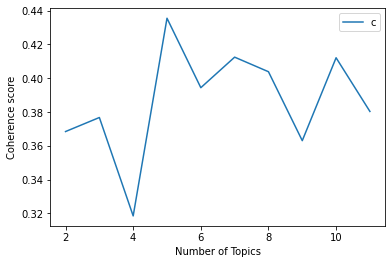

In [28]:
start,stop,step=2,12,1
plot_graph(preproc,start,stop,step)

In [29]:
model=create_gensim_lsa_model(preproc,5,10)

[(0, '0.637*"co" + 0.635*"http" + 0.130*"get" + 0.113*"uk" + 0.089*"amp" + 0.088*"today" + 0.086*"peopl" + 0.085*"countri" + 0.070*"work" + 0.063*"brexit"'), (1, '0.697*"get" + 0.328*"done" + 0.322*"brexit" + -0.189*"amp" + 0.152*"let" + -0.141*"co" + -0.138*"http" + 0.129*"countri" + 0.117*"peopl" + 0.110*"jab"'), (2, '-0.495*"uk" + -0.482*"amp" + -0.235*"work" + 0.233*"http" + 0.230*"co" + -0.165*"peopl" + -0.132*"today" + -0.119*"forward" + -0.103*"us" + -0.102*"vaccin"'), (3, '0.504*"amp" + -0.278*"vaccin" + 0.254*"brexit" + -0.250*"peopl" + 0.218*"done" + -0.202*"thank" + -0.170*"live" + -0.164*"protect" + -0.149*"jab" + 0.147*"get"'), (4, '0.446*"amp" + -0.319*"today" + -0.288*"work" + -0.260*"countri" + 0.226*"vaccin" + 0.193*"jab" + 0.177*"peopl" + -0.158*"year" + 0.145*"get" + -0.139*"new"')]


## Using date to plot

In [30]:
boris['date'] = pd.to_datetime(boris['date']).dt.date

(16526.0, 19074.0)

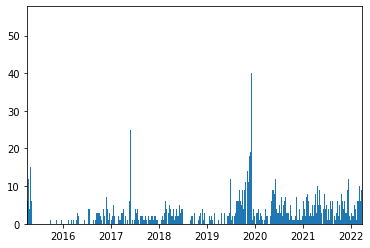

In [32]:
plt.hist(boris.date, bins=len(boris.date.unique()))
plt.xlim(min(boris.date),max(boris.date))

<AxesSubplot:xlabel='date', ylabel='Count'>

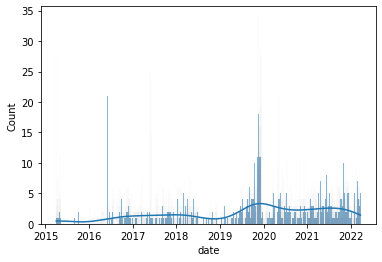

In [33]:
sns.histplot(data=boris.date, kde=True)

Average number of tweets per day (not including days of not tweeting)

In [71]:
boris['num_tweets'] = boris.groupby(['date'])['content'].transform('count')

In [72]:
boris.head()

,id,url,date,content,hashtags,cashtags,media,lang,clean_translation,polarity,objectivity,num_tweets
0,1506711585468911621,https://twitter.com/BorisJohnson/status/150671...,2022-03-23,In 2019 I promised to equalise National Insura...,['SpringStatement2022'],NaN,NaN,en,promised equalise national insurance income ta...,0.000,0.100000,5
1,1506684769559621633,https://twitter.com/BorisJohnson/status/150668...,2022-03-23,I spoke to President @ZelenskyyUa and reiterat...,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.Photo', '...",en,spoke president zelenskyyua reiterated uk ’ ho...,0.000,0.000000,5
2,1506675316273692678,https://twitter.com/BorisJohnson/status/150667...,2022-03-23,Those lost to Covid will never be out of our h...,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.Photo', '...",en,lost covid never hearts minds today reflect na...,0.000,0.000000,5
3,1506647014209200130,https://twitter.com/BorisJohnson/status/150664...,2022-03-23,We're cutting taxes for hardworking people:\n ...,NaN,NaN,NaN,en,cutting taxes hardworking people matching nics...,-0.310,0.631667,5
4,1506588800868392962,https://twitter.com/BorisJohnson/status/150658...,2022-03-23,The UK &amp; Ireland bid for the UEFA Euro 202...,NaN,NaN,NaN,en,uk amp ireland bid uefa euro government ’ full...,0.375,0.725000,5


<AxesSubplot:xlabel='objectivity', ylabel='polarity'>

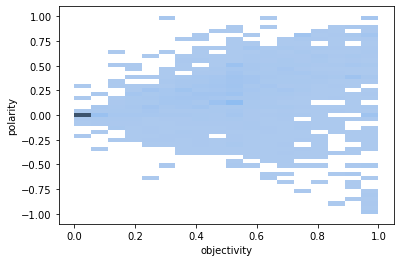

In [39]:
sns.histplot(x = boris.objectivity, y =boris.polarity)

In [42]:
vectorizer = TfidfVectorizer().fit(boris['clean_translation'])

content_vectorized = vectorizer.transform(boris['clean_translation'])


<AxesSubplot:>

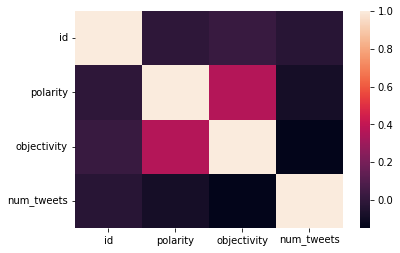

In [78]:
boris_heatmap = boris.drop(columns = ['url', 'content', 'hashtags','media','lang','date','clean_translation','cashtags'])
sns.heatmap(boris_heatmap.corr())

**No significant correlation between number of tweets on a certain day with the objectivity or polarity**

*Twitter username*

In [112]:
#username = 'borisjohnson'
url = f'https://twitter.com/{username}?lang=hu'
#url = 'https://stackoverflow.com/questions/27129675/beautifulsoup-typeerror-nonetype-object-is-not-subscriptable'
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

In [113]:
response.content

b'<!DOCTYPE html>\n<html dir="ltr" lang="hu">\n<meta charset="utf-8" />\n<meta name="viewport" content="width=device-width,initial-scale=1,maximum-scale=1,user-scalable=0,viewport-fit=cover" /><link rel="preconnect" href="//abs.twimg.com" /><link rel="dns-prefetch" href="//abs.twimg.com" /><link rel="preconnect" href="//api.twitter.com" /><link rel="dns-prefetch" href="//api.twitter.com" /><link rel="preconnect" href="//pbs.twimg.com" /><link rel="dns-prefetch" href="//pbs.twimg.com" /><link rel="preconnect" href="//t.co" /><link rel="dns-prefetch" href="//t.co" /><link rel="preconnect" href="//video.twimg.com" /><link rel="dns-prefetch" href="//video.twimg.com" /><link rel="preload" as="script" crossorigin="anonymous" href="https://abs.twimg.com/responsive-web/client-web-legacy/polyfills.0b7908b5.js" nonce="NzI2M2Y1YjctMjU0Yy00M2UwLTg3ZmQtYzQxNjdhZjcwMDky" /><link rel="preload" as="script" crossorigin="anonymous" href="https://abs.twimg.com/responsive-web/client-web-legacy/vendors~mai

In [92]:
import bs4
text = '''<a class="Label" href="_link_">_text_</a>'''
soup = bs4.BeautifulSoup(text)
link = soup.find("a",{"class":"Label"})
print (link["href"])

None


In [98]:
response.content

b'<!DOCTYPE html>\n<html dir="ltr" lang="en">\n<meta charset="utf-8" />\n<meta name="viewport" content="width=device-width,initial-scale=1,maximum-scale=1,user-scalable=0,viewport-fit=cover" /><link rel="preconnect" href="//abs.twimg.com" /><link rel="dns-prefetch" href="//abs.twimg.com" /><link rel="preconnect" href="//api.twitter.com" /><link rel="dns-prefetch" href="//api.twitter.com" /><link rel="preconnect" href="//pbs.twimg.com" /><link rel="dns-prefetch" href="//pbs.twimg.com" /><link rel="preconnect" href="//t.co" /><link rel="dns-prefetch" href="//t.co" /><link rel="preconnect" href="//video.twimg.com" /><link rel="dns-prefetch" href="//video.twimg.com" /><link rel="preload" as="script" crossorigin="anonymous" href="https://abs.twimg.com/responsive-web/client-web-legacy/polyfills.0b7908b5.js" nonce="NTQ2NjZkOWYtODg4OS00M2I4LTg1ZjItN2M5YmI3MzJkY2Nk" /><link rel="preload" as="script" crossorigin="anonymous" href="https://abs.twimg.com/responsive-web/client-web-legacy/vendors~mai